In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('train_modified.csv')

In [3]:
df.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
df.columns

Index(['Disbursed', 'Existing_EMI', 'ID', 'Loan_Amount_Applied',
       'Loan_Tenure_Applied', 'Monthly_Income', 'Var4', 'Var5', 'Age',
       'EMI_Loan_Submitted_Missing', 'Interest_Rate_Missing',
       'Loan_Amount_Submitted_Missing', 'Loan_Tenure_Submitted_Missing',
       'Processing_Fee_Missing', 'Device_Type_0', 'Device_Type_1',
       'Filled_Form_0', 'Filled_Form_1', 'Gender_0', 'Gender_1', 'Var1_0',
       'Var1_1', 'Var1_2', 'Var1_3', 'Var1_4', 'Var1_5', 'Var1_6', 'Var1_7',
       'Var1_8', 'Var1_9', 'Var1_10', 'Var1_11', 'Var1_12', 'Var1_13',
       'Var1_14', 'Var1_15', 'Var1_16', 'Var1_17', 'Var1_18', 'Var2_0',
       'Var2_1', 'Var2_2', 'Var2_3', 'Var2_4', 'Var2_5', 'Var2_6',
       'Mobile_Verified_0', 'Mobile_Verified_1', 'Source_0', 'Source_1',
       'Source_2'],
      dtype='object')

In [5]:
from sklearn.ensemble import GradientBoostingClassifier #GBM Algorith
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV #to perform gridsearch

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,4

Before proceeding further, lets define a function which will help us create GBM models and perform cross-validation.

* Lets start by creating a baseline model. In this case, the evaluation metric is AUC so using any constant value will give 0.5 as result. Typically, a good baseline can be a GBM model with default parameters, i.e. without any tuning. Lets find out what it gives:

In [7]:
target = 'Disbursed'
IDcol = 'ID'

In [8]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" %accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" %roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.831884 | Std - 0.009558427 | Min - 0.8195451 | Max - 0.8438424


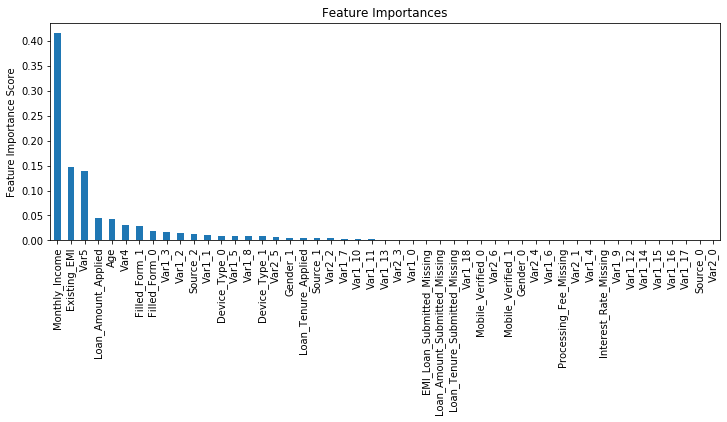

In [9]:
#Choose all predictors except target & IDcols
predictors = [x for x in df.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, df, predictors)

So, the mean CV score is 0.8319 and we should expect our model to do better than this.

### General Approach for Parameter Tuning

* As discussed earlier, there are two types of parameter to be tuned here – tree based and boosting parameters. There are no optimum values for learning rate as low values always work better, given that we train on sufficient number of trees.

* Though, GBM is robust enough to not overfit with increasing trees, but a high number for pa particular learning rate can lead to overfitting. But as we reduce the learning rate and increase trees, the computation becomes expensive and would take a long time to run on standard personal computers.

Keeping all this in mind, we can take the following approach:

* Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems.
* Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
* Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
* Lower the learning rate and increase the estimators proportionally to get more robust models.

### Fix learning rate and number of estimators for tuning tree-based parametersvFix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
* min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
* max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
* max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
* subsample = 0.8 : This is a commonly used used start value

* Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees for that. For this purpose, we can do a grid search and test out values from 20 to 80 in steps of 10.

In [10]:
# Choose all predictors except target and IDcols
predictors=[ x for x in df.columns if x not in[target,IDcol]]
param_test1={'n_estimators':range(20,80,10)}
gsearch1=GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,min_samples_split=500,
                                                          min_samples_leaf=50,max_depth=8,max_features='sqrt',
                                                          subsample=0.8,random_state=10),param_grid=param_test1,
                     scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch1.fit(df[predictors],df[target])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [11]:
gsearch1.best_params_,gsearch1.best_score_

({'n_estimators': 60}, 0.8374927603585836)

* As you can see that here we got 60 as the optimal estimators for 0.1 learning rate. Note that 60 is a reasonable value and can be used as it is. But it might not be the same in all cases. Other situations:

* If the value is around 20, you might want to try lowering the learning rate to 0.05 and re-run grid search.
* If the values are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate.

### Tuning tree-specific parameters

Now lets move onto tuning the tree parameters. I plan to do this in following stages:

* Tune max_depth and min_samples_split
* Tune min_samples_leaf
* Tune max_features


The order of tuning variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we’re tuning those first.

#### Important Note:
* I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

To start with, I’ll test max_depth values of 5 to 15 in steps of 2 and min_samples_split from 200 to 1000 in steps of 200. These are just based on my intuition. You can set wider ranges as well and then perform multiple iterations for smaller ranges.

In [12]:
param_test2={'max_depth':range(5,16,2),'min_samples_split':range(200,1001,200)}
gsearch2=GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=60,max_features='sqrt',
                                                          subsample=0.8,random_state=10),
                     param_grid=param_test2,scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch2.fit(df[predictors],df[target])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=60,
                                                  n_iter_no_change=None,
        

In [13]:
gsearch2.best_params_,gsearch2.best_score_

({'max_depth': 7, 'min_samples_split': 600}, 0.8363840308426287)

* Here, we have run 30 combinations and the ideal values are 7 for max_depth and 600 for min_samples_split. Note that, 1000 is an extreme value which we tested. There is a fare chance that the optimum value lies above that. So we should check for some higher values as well.

* Here, I’ll take the max_depth of 9 as optimum and now try different values for higher min_samples_split. It might not be the best idea always but here if you observe the output closely, max_depth of 9 works better in most of the cases. Also, we can test for 5 values of min_samples_leaf, from 30 to 70 in steps of 10, along with higher min_samples_split.

In [16]:
paramtest3={"min_samples_split":range(1000,2100,200),"min_samples_leaf":range(30,71,10)}
gsearch3=GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=60,max_depth=9,
                                                                   max_features='sqrt',subsample=0.8,random_state=10),
                             param_grid=paramtest3,scoring='roc_auc',n_jobs=4,cv=5)
gsearch3.fit(df[predictors],df[target])
gsearch3.best_params_,gsearch3.best_score_

({'min_samples_leaf': 70, 'min_samples_split': 1000}, 0.8382401463617792)

In [20]:
param_test3={"min_samples_leaf":range(30,71,10),'min_samples_split':range(600,1500,200)}
gsearch3=GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=60,max_depth=7,
                                                                   max_features='sqrt',min_samples_split=600,subsample=0.8,random_state=10),
                             param_grid=paramtest3,scoring='roc_auc',n_jobs=4,cv=5)
gsearch3.fit(df[predictors],df[target])
gsearch3.best_params_,gsearch3.best_score_

({'min_samples_leaf': 60, 'min_samples_split': 1000}, 0.838011507594177)

* Here we get the optimum values as 1000 for min_samples_split and 70 for min_samples_leaf. Also, we can see the CV score increasing to 0.8396 now. Let’s fit the model again on this and have a look at the feature importance.


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.900327
CV Score : Mean - 0.8382401 | Std - 0.009018543 | Min - 0.82662 | Max - 0.8490743


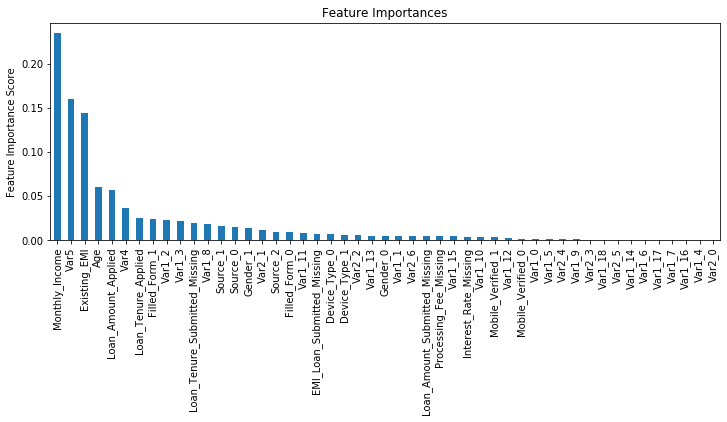

In [17]:
modelfit(gsearch3.best_estimator_,df,predictors)

If you compare the feature importance of this model with the baseline model, you’ll find that now we are able to derive value from many more variables. Also, earlier it placed too much importance on some variables but now it has been fairly distributed.

Now lets tune the last tree-parameters, i.e. max_features by trying 7 values from 7 to 19 in steps of 2.

In [21]:
param_test4={'max_features':range(7,20,2)}
gsearch4=GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=60,max_depth=7,
                                                          min_samples_split=1000,min_samples_leaf=60,
                                                          subsample=0.8,random_state=10),
                     param_grid=param_test4,scoring='roc_auc',n_jobs=4,cv=5)
gsearch4.fit(df[predictors],df[target])
gsearch4.best_params_,gsearch4.best_score_

({'max_features': 17}, 0.8402079882965943)

* Here, we find that optimum value is 17, which is also the square root. So our initial value was the best. You might be anxious to check for lower values and you should if you like. I’ll stay with 17 for now. With this we have the final tree-parameters as:

* min_samples_split: 1000
* min_samples_leaf:60
* max_depth: 7
* max_features: 17

### Tuning subsample and making models with lower learning rate

The next step would be try different subsample values. Lets take values 0.6,0.7,0.75,0.8,0.85,0.9.

In [23]:
param_test5={'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5=GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=60,max_depth=7,learning_rate=0.1,
                                                          min_samples_split=1000,min_samples_leaf=60,
                                                          subsample=0.8,random_state=10,max_features=17),
                     param_grid=param_test5,scoring='roc_auc',n_jobs=4,cv=5)
gsearch5.fit(df[predictors],df[target])
gsearch5.best_params_,gsearch5.best_score_

({'subsample': 0.8}, 0.8402079882965943)

Here, we found 0.8 as the optimum value. Finally, we have all the parameters needed. Now, we need to lower the learning rate and increase the number of estimators proportionally. Note that these trees might not be the most optimum values but a good benchmark.

As trees increase, it will become increasingly computationally expensive to perform CV and find the optimum values. For you to get some idea of the model performance, I have included the private leaderboard scores for each. Since the data is not open, you won’t be able to replicate that but it’ll good for understanding.

Lets decrease the learning rate to half, i.e. 0.05 with twice (120) the number of trees.


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.889756
CV Score : Mean - 0.8400531 | Std - 0.008944102 | Min - 0.8302003 | Max - 0.8514546


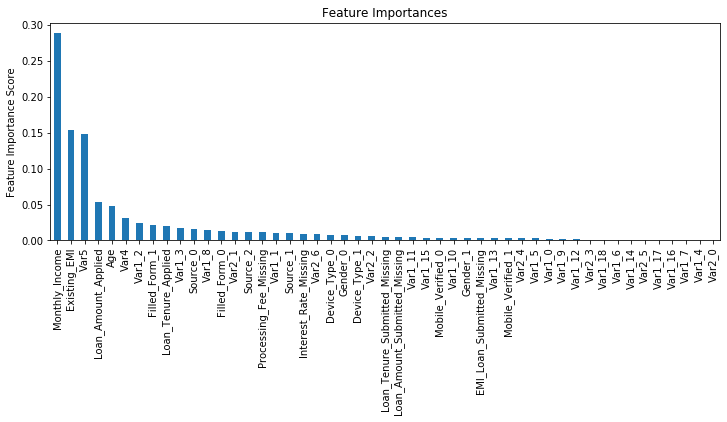

In [25]:
predictors=[x for x in df.columns if x not in [target,IDcol]]
gbm_tuned1=GradientBoostingClassifier(learning_rate=0.05,n_estimators=120,max_depth=7,min_samples_split=1000,
                                     min_samples_leaf=60,subsample=0.8,random_state=10,max_features=15)
modelfit(gbm_tuned1,df,predictors)

* Now lets reduce to one-tenth of the original value, i.e. 0.01 for 600 trees.


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.892424
CV Score : Mean - 0.8407018 | Std - 0.008644562 | Min - 0.8301965 | Max - 0.8512275


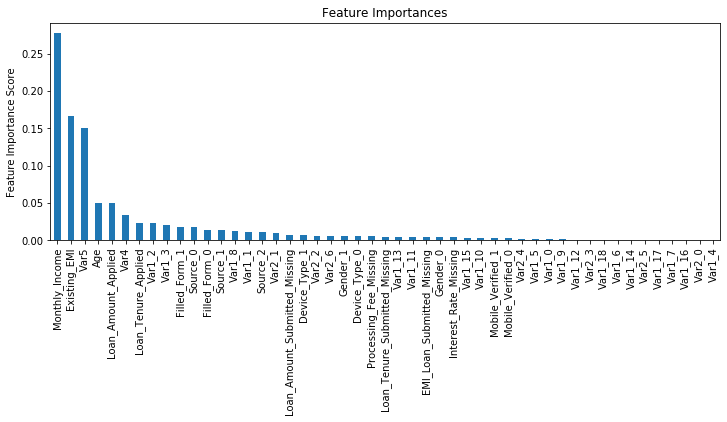

In [26]:
predictors=[x for x in df.columns if x not in [target,IDcol]]
gbm_tuned2=GradientBoostingClassifier(learning_rate=0.01,n_estimators=600,max_depth=7,min_samples_split=1000,
                                     min_samples_leaf=60,subsample=0.8,random_state=10,max_features=15)
modelfit(gbm_tuned2,df,predictors)

* Lets decrease to one-twentieth of the original value, i.e. 0.005 for 1200 trees.


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.892424
CV Score : Mean - 0.8407018 | Std - 0.008644562 | Min - 0.8301965 | Max - 0.8512275


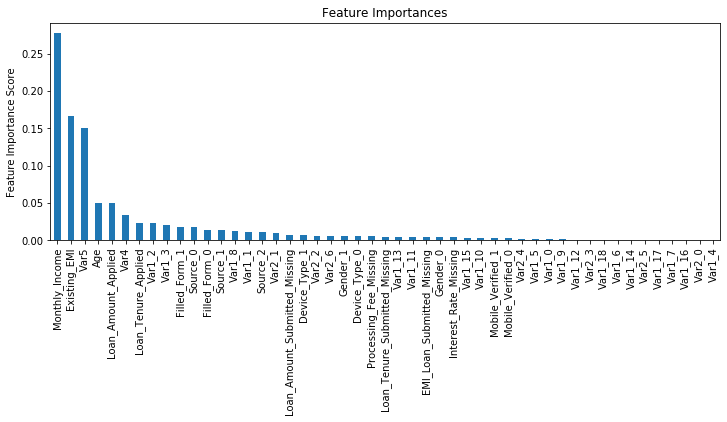

In [27]:
predictors=[x for x in df.columns if x not in [target,IDcol]]
gbm_tuned3=GradientBoostingClassifier(learning_rate=0.005,n_estimators=1200,max_depth=7,min_samples_split=1000,
                                     min_samples_leaf=60,subsample=0.8,random_state=10,max_features=15)
modelfit(gbm_tuned2,df,predictors)

Here we see that the score reduced very slightly. So lets run for 1500 trees.


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.890654


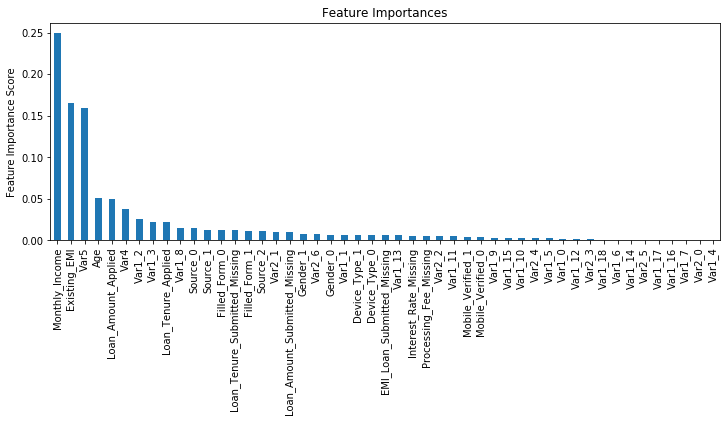

In [28]:
predictors = [x for x in df.columns if x not in [target, IDcol]]
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=7, min_samples_split=1000, min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,
warm_start=True)
modelfit(gbm_tuned_4, df, predictors, performCV=False)

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/?utm_source=blog&utm_medium=4-boosting-algorithms-machine-learning